# ЗАДАЧА 

На основе данных использования мобильного приложения для продажи продуктов питания проанализировать воронку продаж, а также оценить результаты A/A/B-тестирования. 

Эксперимент: изменение шрифтов в приложении. Цель исследования: оценить, повлияло ли это изменение на конверсию.

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats 
from pandas import option_context
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from plotly import tools
from plotly.offline import iplot
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import datetime as dt
from datetime import datetime
import re
from scipy import stats as st

import math as mth

# оставим в числах в таблицах два знака после запятой для удобства
pd.options.display.float_format = '{:,.5f}'.format

# отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
  df = pd.read_csv('/datasets/logs_exp.csv', delimiter='\t+')
except:
  !gdown --id 17X7h8K9CV_thUgwkwLQ9lCUu1Km-1rtc
  df = pd.read_csv('/content/logs_exp.csv', delimiter='\t+')


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17X7h8K9CV_thUgwkwLQ9lCUu1Km-1rtc
To: /content/logs_exp.csv
100% 13.2M/13.2M [00:00<00:00, 53.1MB/s]


# Предобработка данных

Посмотрим на структуру датасета и общую информацию:

In [3]:
df.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
168760,CartScreenAppear,4867798674969477834,1565024057,248
26125,MainScreenAppear,5980202497560802833,1564672635,248
76710,CartScreenAppear,6659583836596679685,1564809582,246
155140,MainScreenAppear,4202933931341256638,1565005180,246
203521,PaymentScreenSuccessful,8280727559464778830,1565108902,248
165769,PaymentScreenSuccessful,4705890939205361551,1565019983,246
34061,MainScreenAppear,1270193576696087003,1564684282,248
198746,MainScreenAppear,28755862496905658,1565102299,247
31812,CartScreenAppear,7738058666231999878,1564680825,246
139457,MainScreenAppear,4818906496725430907,1564950640,246


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В таблице 5 столбов и 244126 строк

Переименуем колонки для удобства и переведем значения `'event_name'` в нижний регистр

In [5]:
df = df.rename(columns={
    'EventName' : 'event_name',
    'DeviceIDHash' : 'id',
    'EventTimestamp' : 'time',
    'ExpId' : 'group'
}
              )

df['event_name'] = (df['event_name']
                    .str.replace('MainScreenAppear', 'main_screen_appear')
                    .str.replace('PaymentScreenSuccessful', 'payment_screen_succesful')
                    .str.replace('CartScreenAppear', 'cart_screen_appear')
                    .str.replace('OffersScreenAppear', 'offers_screen_appear')
                    .str.replace('Tutorial', 'tutorial'))
                   
df.head()

,event_name,id,time,group
0,main_screen_appear,4575588528974610257,1564029816,246
1,main_screen_appear,7416695313311560658,1564053102,246
2,payment_screen_succesful,3518123091307005509,1564054127,248
3,cart_screen_appear,3518123091307005509,1564054127,248
4,payment_screen_succesful,6217807653094995999,1564055322,248


Приведем время в нужный формат и долбавим столбец с датой:

In [6]:
df['time'] = pd.to_datetime(df['time'], unit='s')
df['date'] = df['time'].dt.date

Описание данных в столбцах:

- event_name — название события;

- id — уникальный идентификатор пользователя;

- time — время события;

- date - дата события;

- group: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Проверим данные на дубликаты и пропуски

In [7]:
df.isna().mean()

event_name   0.00000
id           0.00000
time         0.00000
group        0.00000
date         0.00000
dtype: float64

Пропусков в данных нет. Проверим на дубликаты:

In [8]:
df.duplicated().sum()

413

Обнаружено 413 дубликатов. Посмотрим на них подробнее:

In [9]:
dupl = df[df.duplicated() == True]
dupl.head()

,event_name,id,time,group,date
453,main_screen_appear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2350,cart_screen_appear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3573,main_screen_appear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
4076,main_screen_appear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01
4803,main_screen_appear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01


Посмотрим по id одного из пользователей:

In [10]:
df.query('id == 434103746454591587').head()

,event_name,id,time,group,date
3572,main_screen_appear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
3573,main_screen_appear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
16932,main_screen_appear,434103746454591587,2019-08-01 11:37:44,248,2019-08-01
17876,main_screen_appear,434103746454591587,2019-08-01 12:02:36,248,2019-08-01
18333,main_screen_appear,434103746454591587,2019-08-01 12:14:00,248,2019-08-01


Действительно есть полностью совпадающие строки - например, в таблице сверху первые две строки.

У скольких пользователей есть дубликаты и как они распределены по группам:

In [11]:
dupl.groupby('group')['id'].nunique()

group
246    76
247    82
248    79
Name: id, dtype: int64

Дубликатов немного и они распространены по группам достаточно равномерно, поэтому просто удалим их. Предположим, что они возникли из-за ошибок в логировании - некоторые события логировались дважды. Сообщим это дата-инженерам.

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

**Данные обработаны и готовы к дальнейшему анализу.**

# Анализ данных

## Количество событий и пользователей

In [13]:
events_total = df['event_name'].count()
users_total = df['id'].nunique()
print(f'ОБщее число событий: {events_total}. Общее число уникальных пользователей: {users_total}')

ОБщее число событий: 243713. Общее число уникальных пользователей: 7551


In [14]:
print(f'На одного пользователя приходится в среднем {round(events_total / users_total, 2)} событий')

На одного пользователя приходится в среднем 32.28 событий


Соберем таблицу, где каждому пользователю будет соответствовать общее  количество событий:

In [15]:
id_events = (df
             .groupby('id')['event_name']
             .count()
             .reset_index()
             .rename(columns={
                 'event_name' : 'event_count'
             }
             )
             )
id_events.head()

,id,event_count
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


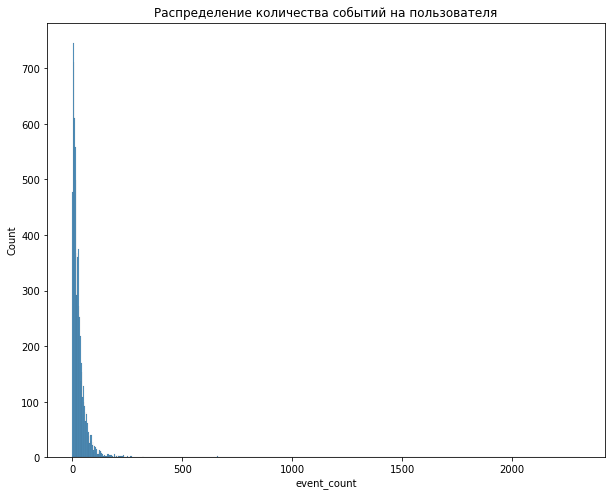

In [16]:
fig = plt.figure(figsize=(10,8))
sns.histplot(data=id_events['event_count'], palette='Blues_d')
plt.title('Распределение количества событий на пользователя')
plt.show()

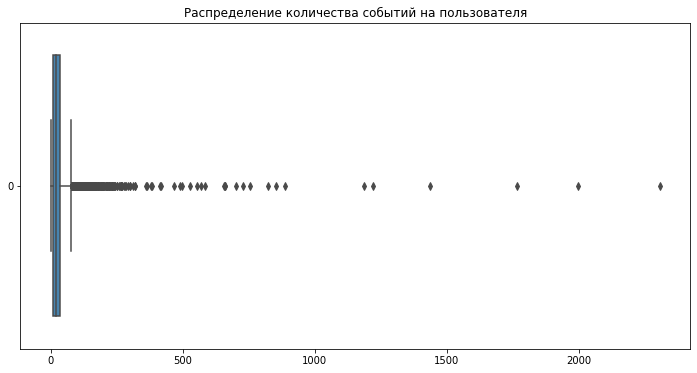

In [17]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=id_events['event_count'], palette='Blues_d', orient='h')
plt.title('Распределение количества событий на пользователя')
plt.show()

По распределению количества событий видим, что есть выбросы. Имеет смысл проверить и медианное число событий на пользователя

In [18]:
id_events['event_count'].median()

20.0

Посмотрим, медианное число заказов  на пользователя:

In [19]:
df.query('event_name == "payment_screen_succesful"').groupby('id')['event_name'].count().median()

4.0

Сделаем сводную таблицу, где каждому пользователю будет соответствовать количество каждого события:

In [20]:
events_user = df.pivot_table(index='id', columns='event_name', values='time', aggfunc='count').reset_index()
events_user.head()

event_name,id,cart_screen_appear,main_screen_appear,offers_screen_appear,payment_screen_succesful,tutorial
0,6888746892508752,NaN,1.00000,NaN,NaN,NaN
1,6909561520679493,1.00000,2.00000,1.00000,1.00000,NaN
2,6922444491712477,8.00000,19.00000,12.00000,8.00000,NaN
3,7435777799948366,NaN,6.00000,NaN,NaN,NaN
4,7702139951469979,5.00000,40.00000,87.00000,5.00000,NaN


Посмотрим на параметры распределений:

In [21]:
events_user.drop('id', axis=1).describe()

event_name,cart_screen_appear,main_screen_appear,offers_screen_appear,payment_screen_succesful,tutorial
count,"3,749.00000","7,439.00000","4,613.00000","3,547.00000",847.00000
mean,11.38117,16.01035,10.14698,9.61883,1.20189
std,37.95791,16.26676,16.01949,36.70921,1.16513
min,1.00000,1.00000,1.00000,1.00000,1.00000
25%,3.00000,6.00000,3.00000,2.00000,1.00000
50%,5.00000,11.00000,6.00000,4.00000,1.00000
75%,11.00000,21.00000,12.00000,8.00000,1.00000
max,"1,100.00000",206.00000,509.00000,"1,085.00000",27.00000


Видим, что во всех распределениях событий средние значения больше медианных из-за выбросов.

Визуализируем распределения всех событий на пользователя:

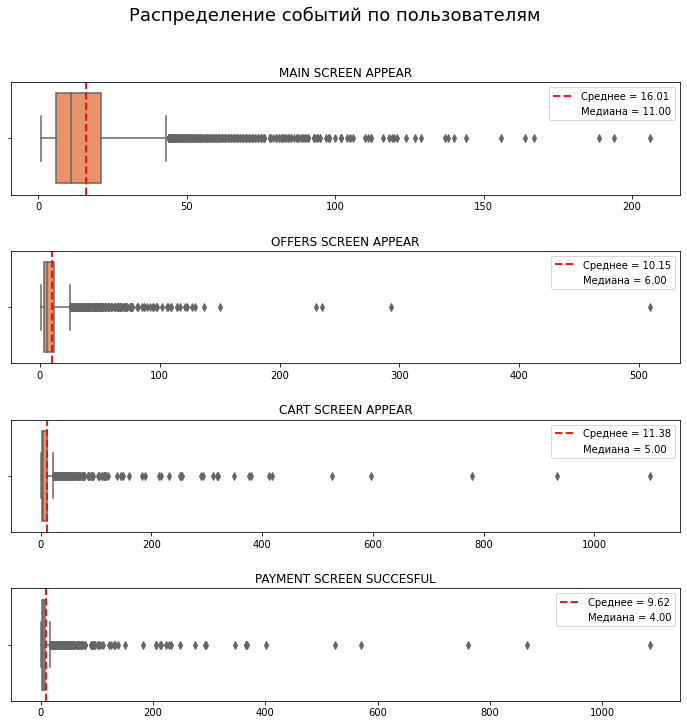

In [22]:
cols = ['main_screen_appear',
        'offers_screen_appear',
        'cart_screen_appear',
        'payment_screen_succesful'
        ]
plt.figure(figsize=(12,30))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Распределение событий по пользователям", fontsize=18, y=0.915)

for n, col in enumerate(cols):
    ax = plt.subplot(10, 1, n + 1)
    g = sns.boxplot(data=events_user, x=col, palette="OrRd")
    ax.set_title(col.upper().replace('_', ' '))
    g.axvline(np.mean(events_user[col]), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(events_user[col])))
    g.axvline(events_user[col].median(), 
               linewidth=2, 
               color='g', 
               alpha=0, 
               linestyle='--', 
               label = 'Медиана = {:,.2f}'.format(events_user[col].median()))
    ax.set_xlabel("")
    plt.legend()

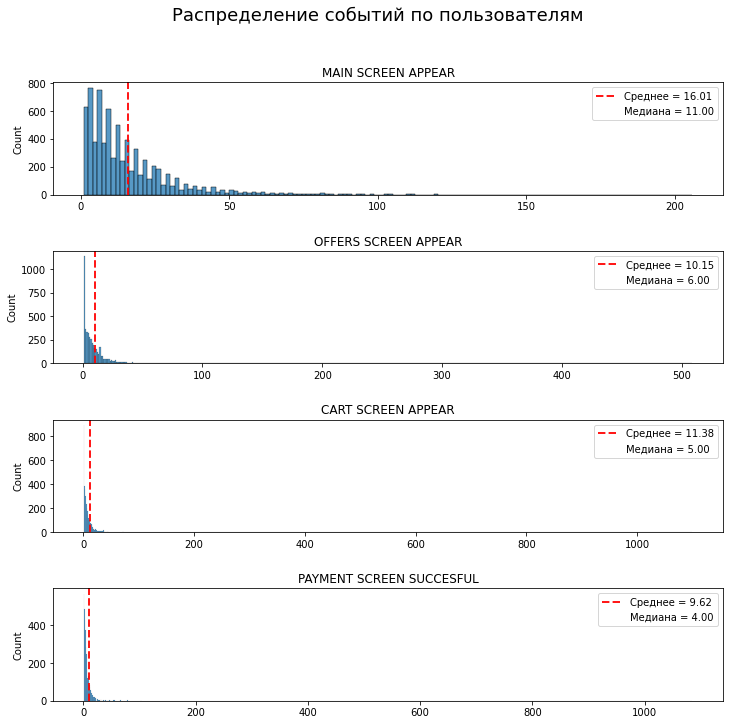

In [23]:
cols = ['main_screen_appear',
        'offers_screen_appear',
        'cart_screen_appear',
        'payment_screen_succesful'
        ]
plt.figure(figsize=(12,30))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Распределение событий по пользователям", fontsize=18, y=0.915)

for n, col in enumerate(cols):
    ax = plt.subplot(10, 1, n + 1)
    g = sns.histplot(data=events_user, x=col, palette="OrRd")
    ax.set_title(col.upper().replace('_', ' '))
    g.axvline(np.mean(events_user[col]), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(events_user[col])))
    g.axvline(events_user[col].median(), 
               linewidth=2, 
               color='g', 
               alpha=0, 
               linestyle='--', 
               label = 'Медиана = {:,.2f}'.format(events_user[col].median()))
    ax.set_xlabel("")
    plt.legend()

Видим, что распределения неравномерны и сильно скошены. Это означает, что мы не сможем использовать параметрический статистический тест для проверки гипотез.

## Период исследования

Изучим внимательно столбцы с датой

In [24]:
df['time'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: time, dtype: object

Минимальная дата: 25.07.2019

Максимальная дата: 07.08.2019

In [25]:
df['date'].describe()

count         243713
unique            14
top       2019-08-01
freq           36141
Name: date, dtype: object

В нашем датасете инфомрация за 14 дней

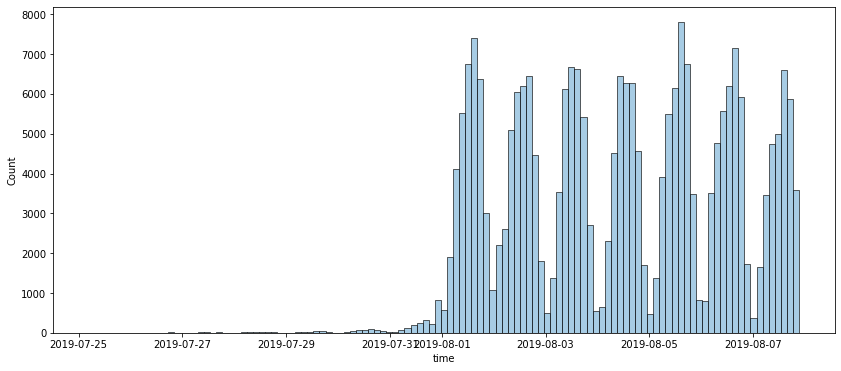

In [26]:
fig = plt.figure(figsize = (14,6))
sns.set_palette('Blues_d')
sns.histplot(data=df['time'])
plt.show()

Из этого графика можно сделать вывод, что основная масса данных приходится на период с первого по восьмое августа.

Посмотрим, какая доля событий не попадает в этот интервал:

In [27]:
len(df.query('time < "2019-08-01"')) / len(df)

0.011595606307418972

Чуть больше одного процента - эти данные мы не будем использовать в дальнейших расчетах

Посмотрим, сколько всего у нас уникальных пользователей:

In [28]:
users_old = df['id'].nunique()
users_old

7551

In [29]:
df = df.query('time >= "2019-08-01"')

Сколько уникальных пользователей после удаления части данных:

In [30]:
users_new = df['id'].nunique()
format((1 - users_new / users_old), '.3%')


'0.225%'

То есть, мы теряем менее 1% уникальных пользователей.

In [31]:
df['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

В данных присутствуют пользователи всех трех групп.

**Принято решение использовать для анализа данные с 1 по 8 августа 2019 года.**

## Воронка событий

Посмотрим на количество событий  и пользователей в таблице. Рассчитаем конверсию от начального числа пользователей и конверсию от предыдущего шага (для наглядности).

Также, исключим из дальнейших расчетов шаг 'tutorial'. Пользователей, просмотревших туториал, достаточно мало. К тому же нас больше интересует конверсия в платящих пользователей. 

In [32]:
df['event_name'].unique()

array(['tutorial', 'main_screen_appear', 'offers_screen_appear',
       'cart_screen_appear', 'payment_screen_succesful'], dtype=object)

Событий всего: 

In [33]:
df['event_name'].count()

240887

Уникальных пользователей:

In [34]:
df['id'].nunique()

7534

Соберем общую таблицу событий для всего эксперимента:

In [35]:
events = df.groupby('event_name').agg({'time' : 'count', 'id' : 'nunique'}).reset_index().sort_values(by='id', ascending=False)
events.columns = ['event_name', 'count', 'users'] # переименуем столбцы
events['users_prev'] = events['users'].shift() # добавим столбец с кол-вом пользователей на предыдущем шаге
events['conversion'] = events['users'] / df['id'].nunique() # найдем конверсию
events['conversion_prev'] = events['users'] / events['users_prev'] # найдем конверсию с предыдущего шага
events = events.query('event_name != "tutorial"')
events

,event_name,count,users,users_prev,conversion,conversion_prev
1,main_screen_appear,117328,7419,NaN,0.98474,NaN
2,offers_screen_appear,46333,4593,"7,419.00000",0.60964,0.61909
0,cart_screen_appear,42303,3734,"4,593.00000",0.49562,0.81298
3,payment_screen_succesful,33918,3539,"3,734.00000",0.46974,0.94778


Видим, что часть пользователей эксперимента не видели главный экран: на этапе main_screen_appear меньше пользователей, чем всего участников эксперимента. Вероятно, это могут быть клиенты, получившие на почту письмо с предложением поучаствовать в промоакции - с прямой ссылкой на товар. 

Для чистоты эксперимента и корректного обсчета воронки такие заказы следует также логировать и исключать из дальнейших расчетов. Либо настроить систему АВ-тестирования таким образом, чтобы участники эксперимента не получали подобных писем.

Построим воронку событий

In [36]:
fig = go.Figure(
    go.Funnel(x = events['users'], 
              y = events['event_name'], 
              textinfo = "value+percent initial+percent previous"))

fig.update_layout(showlegend=False,
                  height=600, 
                  width=800,
                  title_text=f'Воронка событий общая',
                  title_x=0.5)
fig.show()

## Воронки событий для трех групп

Сделаем то же самое для трех групп по отдельности

Напишем функции для создания таблиц и построения воронок по экспериментальным группам

In [37]:
def get_events(data, i):
      table = (data[data['group'] == i] # отбираем пользователей каждой группы
      .groupby('event_name')
      .agg({'time' : 'count', 'id' : 'nunique'}) # считаем кол-во уникальных пользователей и число событий
      .reset_index()
      .sort_values(by='id', ascending=False))
      table.columns = ['event_name', 'count', 'users']

      # «сдвигаем» количество пользователей, чтобы сравнить с предыдущим шагом
      table['users_prev'] = table['users'].shift() 

      # считаем конверсию
      table['conversion'] = table['users'] / df.query('group == @i')['id'].nunique()

      # считаем конверсию на каждом шаге
      table['conversion_prev'] = table['users'] / table['users_prev'] 

      # исключаем событие 'tutorial'
      table = table.query('event_name != "tutorial"') 
      
      return table

In [38]:
def get_funnel(table, i=0):
  data = dict(values=table['users'],
              labels=table['event_name'])

  fig = px.funnel(data, 
                y='labels', 
                x='values')
  fig.update_layout(showlegend=False,
                  height=600, 
                  width=800,
                  title_text=f'Воронка событий {i}',
                  title_x=0.5)
  fig.show()

Создадим таблицы показателей и воронки для всех групп

In [39]:
events_246 = get_events(df, 246)
events_246

,event_name,count,users,users_prev,conversion,conversion_prev
1,main_screen_appear,37676,2450,NaN,0.98631,NaN
2,offers_screen_appear,14767,1542,"2,450.00000",0.62077,0.62939
0,cart_screen_appear,14690,1266,"1,542.00000",0.50966,0.82101
3,payment_screen_succesful,11852,1200,"1,266.00000",0.48309,0.94787


In [40]:
get_funnel(events_246, 246)

In [41]:
events_247 = get_events(df, 247)
events_247

,event_name,count,users,users_prev,conversion,conversion_prev
1,main_screen_appear,39090,2476,NaN,0.98528,NaN
2,offers_screen_appear,15179,1520,"2,476.00000",0.60485,0.61389
0,cart_screen_appear,12434,1238,"1,520.00000",0.49264,0.81447
3,payment_screen_succesful,9981,1158,"1,238.00000",0.46080,0.93538


In [42]:
get_funnel(events_247, 247)

In [43]:
events_248 = get_events(df, 248)
events_248

,event_name,count,users,users_prev,conversion,conversion_prev
1,main_screen_appear,40562,2493,NaN,0.98266,NaN
2,offers_screen_appear,16387,1531,"2,493.00000",0.60347,0.61412
0,cart_screen_appear,15179,1230,"1,531.00000",0.48482,0.80340
3,payment_screen_succesful,12085,1181,"1,230.00000",0.46551,0.96016


In [44]:
get_funnel(events_248, 248)

**Видим, что среди всех трех групп в эксперименте главные потери происходят при переходе от первого шага (главный экран) ко второму (экран с предложением совершить покупку). Численные показатели в разных группах по всем шагам практически не отличаются.**


## Доля пользователей, совершивших покупку

Считаем, что пользователь совершил покупку, если в его логе присутствует событие `'payment_screen_succesful'`

In [45]:
# собираем список пользователей, совершивших покупку
payer_id = df.query('event_name == "payment_screen_succesful"')['id'].unique()
len(payer_id)

3539

Найдем долю пользователей нашей выборки, кто совершил покупку:

In [46]:
df['id'].nunique()

7534

In [47]:
round(len(payer_id) / df['id'].nunique(), 2)

0.47

## Результаты эксперимента



> **DISCLAIMER:** В учебном модуле для расчета конверсии изучался z-тест. Мы используем его, а потом проверим на применимость и проверим результаты при помощи бутстрапа.



Согласно условиям нашего эксперимента, мы должны узнать, как изменились конверсии по шагам воронки. Для подобных расчетов используется z-тест пропроций. 

Найдем, сколько пользователей в каждой группе

In [48]:
df.groupby('group').agg({'id' : 'nunique'}).reset_index().rename(columns={'id' : 'count'})

,group,count
0,246,2484
1,247,2513
2,248,2537


Видим, что размеры групп несколько различаются. Разница небольшая, но, возможно, для будущих тестов стоит оптимизировать систему сплитования.

Проверим, есть ли пересечения между группами:

In [49]:
set_246 = set(df.query('group == 246')['id'].unique().tolist())
set_247 = set(df.query('group == 247')['id'].unique().tolist())
set_248 = set(df.query('group == 248')['id'].unique().tolist())
print(set_246.intersection(set_247))
print(set_246.intersection(set_248))
print(set_247.intersection(set_248))

set()
set()
set()


Пересечений не обнаружено

Для проведения статистических тестов соберем отдельную таблицу, где будут собраны количества пользователей на каждом шаге воронки в каждой из групп

In [50]:
for_test = df.pivot_table(index='event_name', columns='group', values='id', aggfunc='nunique')

for_test.columns = ['g246', 'g247', 'g248']
for_test = for_test.sort_values(by='g246', ascending=False)
for_test = for_test.reset_index(drop=True).drop(labels=4, axis=0) # удаляем шаг 'tutorial'

for_test['g0'] = for_test['g246'] + for_test['g247'] # создаем столбец для объединенной контрольной группы
for_test

,g246,g247,g248,g0
0,2450,2476,2493,4926
1,1542,1520,1531,3062
2,1266,1238,1230,2504
3,1200,1158,1181,2358


Так как мы определили, что не каджый пользователь проходит все шаги воронки, для расчета конверсии будем использовать общее число уникальных пользователей в каждой группе.

Для этого соберем вспомогательную таблицу

In [51]:
groups_users = df.groupby('group')['id'].nunique().reset_index()
groups_users['group'] = groups_users['group'].apply(lambda x : 'g' + str(x))
groups_users = groups_users.T.reset_index(drop=True)
groups_users.columns = groups_users.iloc[0]
groups_users['g0'] = groups_users['g246'] + groups_users['g247']
groups_users = groups_users.drop(labels=0, axis=0)
groups_users

,g246,g247,g248,g0
1,2484,2513,2537,4997


Напишем функцию для проверки статистических различий в конверсии между группами

In [52]:
def get_p(table1, table2, j, m, n):
  tr1 = table2.loc[1, f'g{m}']
  tr2 = table2.loc[1, f'g{n}']

  s1 = table1.loc[j, f'g{m}']
  s2 = table1.loc[j, f'g{n}']

  successes = np.array([s1, s2])
  trials = np.array([tr1, tr2])

  alpha = 0.05

  # пропорция успехов в первой группе:
  p1 = successes[0]/trials[0]

  # пропорция успехов во второй группе:
  p2 = successes[1]/trials[1]

  # пропорция успехов в комбинированном датасете:
  p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

  # разница пропорций в датасетах
  difference = p1 - p2 

  # считаем статистику в ст.отклонениях стандартного нормального распределения
  z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

  # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
  distr = st.norm(0, 1) 

  # считаем статистику в ст.отклонениях стандартного нормального распределения
  z_value = difference / mth.sqrt(
      p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
  )

  # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
  distr = st.norm(0, 1)

  p_value = (1 - distr.cdf(abs(z_value))) * 2

  print(f'p-значение ({m}, {n}, шаг {j+1}): ', p_value)

  if p_value < alpha:
      print('Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница')
  else:
      print(
          'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными'
      ) 

Формулируем нулевую гипотезу: между конверсиями групп нет разницы. Альтернативная гипотеза: конверсия групп отличается.

Сравним группы 246 и 247 по всем шагам воронки. Фактически, это наш АА-тест.

In [53]:
for j in range(4):
  get_p(for_test, groups_users, j, 246, 247)

p-значение (246, 247, шаг 1):  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (246, 247, шаг 2):  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (246, 247, шаг 3):  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (246, 247, шаг 4):  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными


АА-тест показывает, что мы не пожем отвергнуть нулевую гипотезу и статистически значимых различий между контрольными группами нет. Это правильный результат АА-теста.

Сравним группы 246 и 248 по всем шагам воронки:

In [54]:
for j in range(4):
  get_p(for_test, groups_users, j, 246, 248)

p-значение (246, 248, шаг 1):  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (246, 248, шаг 2):  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (246, 248, шаг 3):  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (246, 248, шаг 4):  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными


Сравним группы 247 и 248 по всем шагам воронки:

In [55]:
for j in range(4):
  get_p(for_test, groups_users, j, 247, 248)

p-значение (247, 248, шаг 1):  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (247, 248, шаг 2):  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (247, 248, шаг 3):  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (247, 248, шаг 4):  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными


Сравним объединенную АА-группу с экспериментальной группой 

In [56]:
for j in range(4):
  get_p(for_test, groups_users, j, 0, 248)

p-значение (0, 248, шаг 1):  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (0, 248, шаг 2):  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (0, 248, шаг 3):  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными
p-значение (0, 248, шаг 4):  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными


Мы сделали 16 сравнений в нашем исследовании. В таком случае нам следовало бы применить поправку Бонферрони и разделить выбранный нами уровень значимости на 16 - и посмотреть на результаты. Но т.к. во всех случаях не получилось отвергнуть нулевую гипотезу, то повторной проверки не требуется.

## Проверка z-теста на применимость

Проверим z-тест на применимость к нашему эксперименту.

Возьмем 1000 выборок с возвращением из наших тестовых групп и посмотрим, как распределится значение p-value нашего z-теста. Если распределение будет близко к равномерному, статистический тест пригоден для анализа АВ-эксперимента.

Добавим к исходному датафрейму столбец `flag`, который будет принимать значение `1`, если пользователь совершил покупку, и 0 - если не совершил.

In [59]:
payer_id = payer_id.tolist()

is_payer = []
for _ in df['id']:
  if _ in payer_id:
    is_payer.append(1)
  else:
    is_payer.append(0)
df['flag'] = is_payer



Сгруппируем исходный датафрейм по id пользователя и экспериментальной группе для удобства расчета выборок.

Проверим:

In [60]:
df.groupby('flag')['id'].nunique()

flag
0    3995
1    3539
Name: id, dtype: int64

Результаты сходятся.


In [61]:
df_gr = df.groupby(['id', 'group'])['flag'].mean().reset_index()
df_gr.head()

,id,group,flag
0,6888746892508752,246,0.00000
1,6909561520679493,247,1.00000
2,6922444491712477,246,1.00000
3,7435777799948366,248,0.00000
4,7702139951469979,247,1.00000


In [76]:
p_val = []
for _ in range(1000):
  aa246=df_gr.query('group == 246').sample(len(df_gr.query('group == 246')), replace=True)
  aa247=df_gr.query('group == 247').sample(len(df_gr.query('group == 247')), replace=True)
  u246 = aa246['id'].nunique()
  u247 = aa247['id'].nunique()
  p246 = aa246.query('flag == 1')['id'].nunique()
  p247 = aa247.query('flag == 1')['id'].nunique()

  tr1 = u246
  tr2 = u247
  s1 = p246
  s2 = p247

  successes = np.array([s1, s2])
  trials = np.array([tr1, tr2])

  alpha = 0.05

  # пропорция успехов в первой группе:
  p1 = successes[0]/trials[0]

  # пропорция успехов во второй группе:
  p2 = successes[1]/trials[1]

  # пропорция успехов в комбинированном датасете:
  p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

  # разница пропорций в датасетах
  difference = p1 - p2 

  # считаем статистику в ст.отклонениях стандартного нормального распределения
  z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

  # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
  distr = st.norm(0, 1) 

  # считаем статистику в ст.отклонениях стандартного нормального распределения
  z_value = difference / mth.sqrt(
      p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

  # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
  distr = st.norm(0, 1)

  p_value = (1 - distr.cdf(abs(z_value))) * 2

  p_val.append(p_value)

Визуализируем распределение p-value:

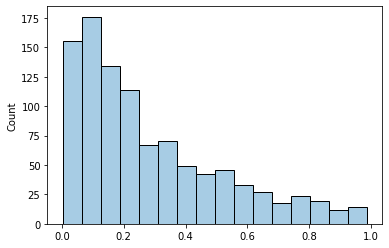

In [77]:
sns.histplot(p_val)
plt.show()

Проверим, в каком проценте случаев тест сработает верно, то есть не найдет отличий в выборках

In [79]:
fnr = []
for p in p_val: 
  if p < 0.05:
    fnr.append(0)
  else:
    fnr.append(1)
np.mean(fnr)

0.886

Расчеты показывают, что применение z-теста оправдано. Однако, проведем сравнение конверсий еще одним методом.

## Bootstrap

Проверим наши результаты при помощи бутстрапа. Для простоты посчитаем только конверсию в покупку.

Напишем функцию для бутстрапа:

In [ ]:
def get_bootstrap(df, j, k, n=10):
  ''' 
  Функция принимает на вход таблицу, номера тестовых групп 
  и количество выборок для бутстрэпа (по умолчанию 1000).

  Функция возвращает характеристики конверсии в сравниваемых группах
  и строит распределения.
  '''
  ctr1 = [] # конверсии в первой группе
  ctr2 = [] # конверсии во второй группе
  diff_list = [] # разница конверсий

  for _ in range(n):
    table1 = df.query(f'group == {j}').sample(2000, replace=True)
    table2 = df.query(f'group == {k}').sample(2000, replace=True)
    u1 = table1.query('flag == 1')['id'].nunique()
    u2 = table2.query('flag == 1')['id'].nunique()
    ctr_1 = u1 / table1['id'].nunique()
    ctr_2 = u2 / table2['id'].nunique()
    ctr1.append(ctr_1)
    ctr2.append(ctr_2)
    diff = np.mean(ctr_1) - np.mean(ctr_2)
    diff_list.append(diff)
    
    mean_1 = np.mean(ctr1)
    mean_2 = np.mean(ctr2)

  diff_list = pd.DataFrame(diff_list)

  pvalue = 2 * min(np.mean(diff_list[0] > 0), np.mean(diff_list[0] < 0))

  print(f'''
p-value = {pvalue}
Среднее значение конверсии первой группы: {round(mean_1, 3)}
Среднее значение конверсии второй группы: {round(mean_2, 3)}

Характеристики распределения конверсии первой группы
{pd.Series(ctr1).describe()}

Характеристики распределения конверсии второй группы
{pd.Series(ctr2).describe()}
''') 
  
  # строим распределения
  plt.figure(figsize = (15,7))

  plt.subplot(1,2,1)
  ax1 = sns.histplot(ctr1, 
                     kde=False, 
                     label=f'Группа {j}',
                     alpha=0.5)
  ax1.axvline(mean_1, 
              linewidth=1, 
              color='k', 
              alpha=0.7, 
              linestyle='--', 
              label='Средние значения в выборках'
              )

  ax1 = sns.histplot(ctr2, 
                     color = 'red', 
                     label=f'Группа {k}',
                     alpha=0.6)
  ax1.axvline(mean_2, 
              linewidth=1, 
              color='k', 
              alpha=0.7, 
              linestyle='--', 
              )
  ax1.set_title('Распределение конверсий в сравниваемых группах')
  plt.legend()

  plt.subplot(1,2,2)
  
  sns.set_style('whitegrid')
  ax2 = sns.histplot((pd.Series(ctr1) - pd.Series(ctr2)), 
                     color = 'lightblue')
  ax2.axvline(diff_list[0].quantile(0.025), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--',
                label='Границы 95% доверительного интервала' 
                )
  ax2.axvline(diff_list[0].quantile(0.975), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--', 
                )
  ax2.set_title('Распределение разницы средних значений конверсий')
  plt.legend()
  plt.tight_layout()
  plt.show()

Сравним между собой попарно наши группы. Начнем с контрольных (246 и 247).


p-value = 0.086
Среднее значение конверсии первой группы: 0.483
Среднее значение конверсии второй группы: 0.461

Характеристики распределения конверсии первой группы
count   1,000.00000
mean        0.48304
std         0.00908
min         0.45461
25%         0.47686
50%         0.48339
75%         0.48916
max         0.50983
dtype: float64

Характеристики распределения конверсии второй группы
count   1,000.00000
mean        0.46116
std         0.00914
min         0.43353
25%         0.45546
50%         0.46120
75%         0.46710
max         0.48935
dtype: float64



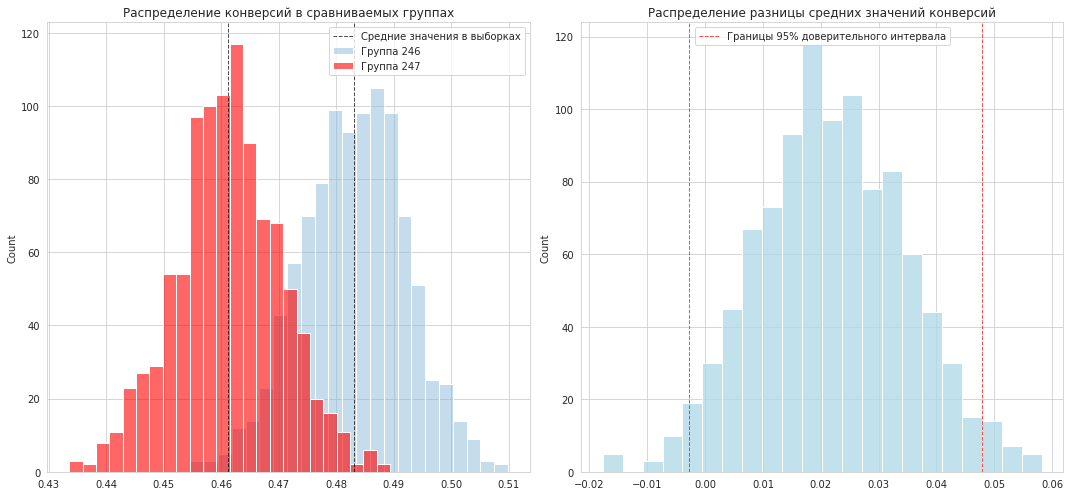

In [ ]:
get_bootstrap(df_gr, 246, 247, 1000)

Видим, чтопри уровне значимости 0.05 бутстрап не показывает статистически значимых отличий между контрольными группами. Это показывает на корректность АА-теста.

Теперь сравним контрольные группы с тестовой:


p-value = 0.174
Среднее значение конверсии первой группы: 0.483
Среднее значение конверсии второй группы: 0.466

Характеристики распределения конверсии первой группы
count   1,000.00000
mean        0.48321
std         0.00909
min         0.45214
25%         0.47743
50%         0.48310
75%         0.48881
max         0.51037
dtype: float64

Характеристики распределения конверсии второй группы
count   1,000.00000
mean        0.46552
std         0.00867
min         0.43193
25%         0.45945
50%         0.46547
75%         0.47149
max         0.49002
dtype: float64



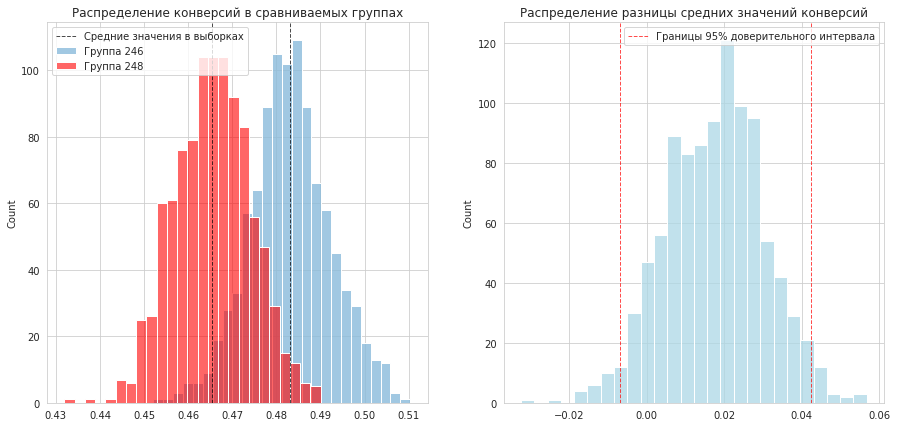

In [ ]:
get_bootstrap(df_gr, 246, 248, 1000)


p-value = 0.69
Среднее значение конверсии первой группы: 0.461
Среднее значение конверсии второй группы: 0.466

Характеристики распределения конверсии первой группы
count   1,000.00000
mean        0.46071
std         0.00894
min         0.43102
25%         0.45481
50%         0.46082
75%         0.46686
max         0.48571
dtype: float64

Характеристики распределения конверсии второй группы
count   1,000.00000
mean        0.46567
std         0.00925
min         0.43627
25%         0.45955
50%         0.46565
75%         0.47187
max         0.49820
dtype: float64



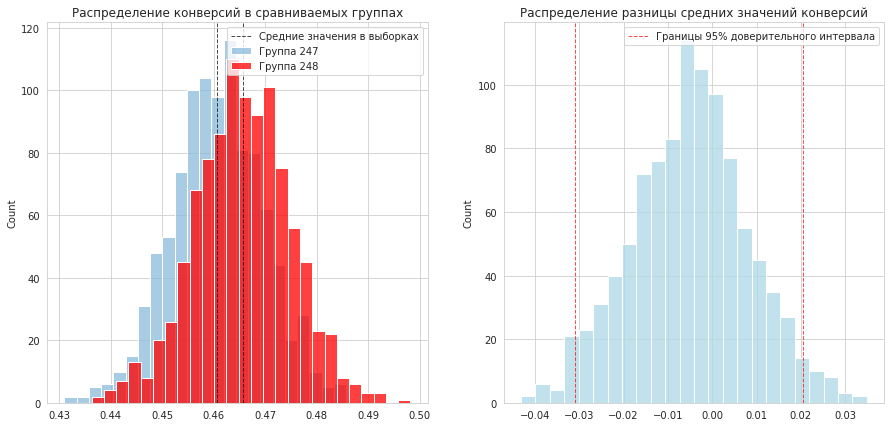

In [ ]:
get_bootstrap(df_gr, 247, 248, 1000)

Бутстрап также не показывает статистически значимых различий между группами.

# Выводы

Изучив всю имеющуюся информацию и проведя статистические тесты, мы обнаружили, что статистически значимые различия между контрольной и экспериментальной группами отсутствуют. Изменение шрифтов в приложении не приводит к значимому изменению конверсии.